# Building a GPT that exhibits grokking

## 1. Single linear layer after embedding

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters

batch_size    = 128
learning_rate = 1e-3
max_iters     = 20_000
eval_interval = 1000
block_size    = 2
eval_interval = 100
device        = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters    = 200
n_embd        = 64

weight_decay = 1e-1
# ------------

torch.manual_seed(1337)




# modular addition dataset
p = 97  # prime modulus
vocab_size = p

def generate_data(n_samples=10000):
    a = torch.randint(0, p, (n_samples,))
    b = torch.randint(0, p, (n_samples,))
    x = torch.stack([a, b], dim=1)  # (N, 2)
    y = (a + b) % p
    return x, y

X, Y = generate_data(p*p)
split = int(0.8 * len(X))
train_X, val_X = X[:split], X[split:]
train_Y, val_Y = Y[:split], Y[split:]

def get_batch(split):
    X = train_X if split == 'train' else val_X
    Y = train_Y if split == 'train' else val_Y
    ix = torch.randint(len(X), (batch_size,))
    return X[ix].to(device), Y[ix].to(device)


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),  # expand the dimensionality
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd)   # project back to embedding size
        )

    def forward(self, x):
        return self.net(x)


class ModAddMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(p, n_embd)
        self.blocks = FeedForward(2 * n_embd) # tiny MLP for arithmetic
        self.head   = nn.Linear(2 * n_embd, p)

    def forward(self, x, y=None):
        x = self.token_embedding(x)      # (B, 2, C)
        x = x.view(x.size(0), -1)        # (B, 2C)
        x = self.blocks(x)

        logits = self.head(x)     # predict sum

        loss = None
        if y is not None:
            loss = F.cross_entropy(logits, y)
        return logits, loss



model = ModAddMLP()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)


train_losses = []
val_losses = []
steps = []


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        steps.append(iter)
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        print(f"step {iter}: train {losses['train']:.4f}, val {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


0.150433 M parameters
step 0: train 4.5823, val 4.5866
step 100: train 4.3032, val 4.6170
step 200: train 3.9441, val 4.6977
step 300: train 3.5306, val 4.7561
step 400: train 3.0879, val 4.7966
step 500: train 2.5737, val 4.7495
step 600: train 2.0867, val 4.6636
step 700: train 1.6328, val 4.5404
step 800: train 1.2644, val 4.4559
step 900: train 0.9289, val 4.3349
step 1000: train 0.6987, val 4.3472
step 1100: train 0.4911, val 4.2523
step 1200: train 0.3392, val 4.2529
step 1300: train 0.2377, val 4.1768
step 1400: train 0.1685, val 4.3075
step 1500: train 0.1201, val 4.2763
step 1600: train 0.0909, val 4.2675
step 1700: train 0.0703, val 4.2382
step 1800: train 0.0609, val 4.2536
step 1900: train 0.0521, val 4.2020
step 2000: train 0.0461, val 4.2191
step 2100: train 0.0421, val 4.1597
step 2200: train 0.0393, val 4.2488
step 2300: train 0.0358, val 4.1653
step 2400: train 0.0336, val 4.1873
step 2500: train 0.0305, val 4.1513
step 2600: train 0.0285, val 4.1196
step 2700: train 0

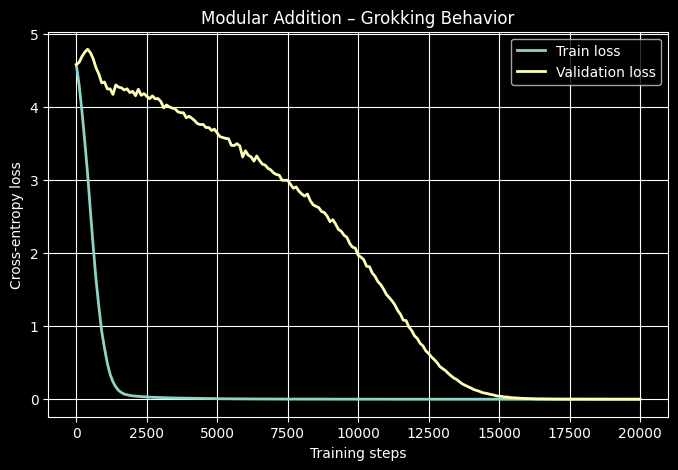

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))


plt.plot(steps, train_losses, label="Train loss", linewidth=2)
plt.plot(steps, val_losses, label="Validation loss", linewidth=2)

plt.xlabel("Training steps")
plt.ylabel("Cross-entropy loss")
plt.title("Modular Addition – Grokking Behavior")
plt.legend()
plt.grid(True)

plt.show()


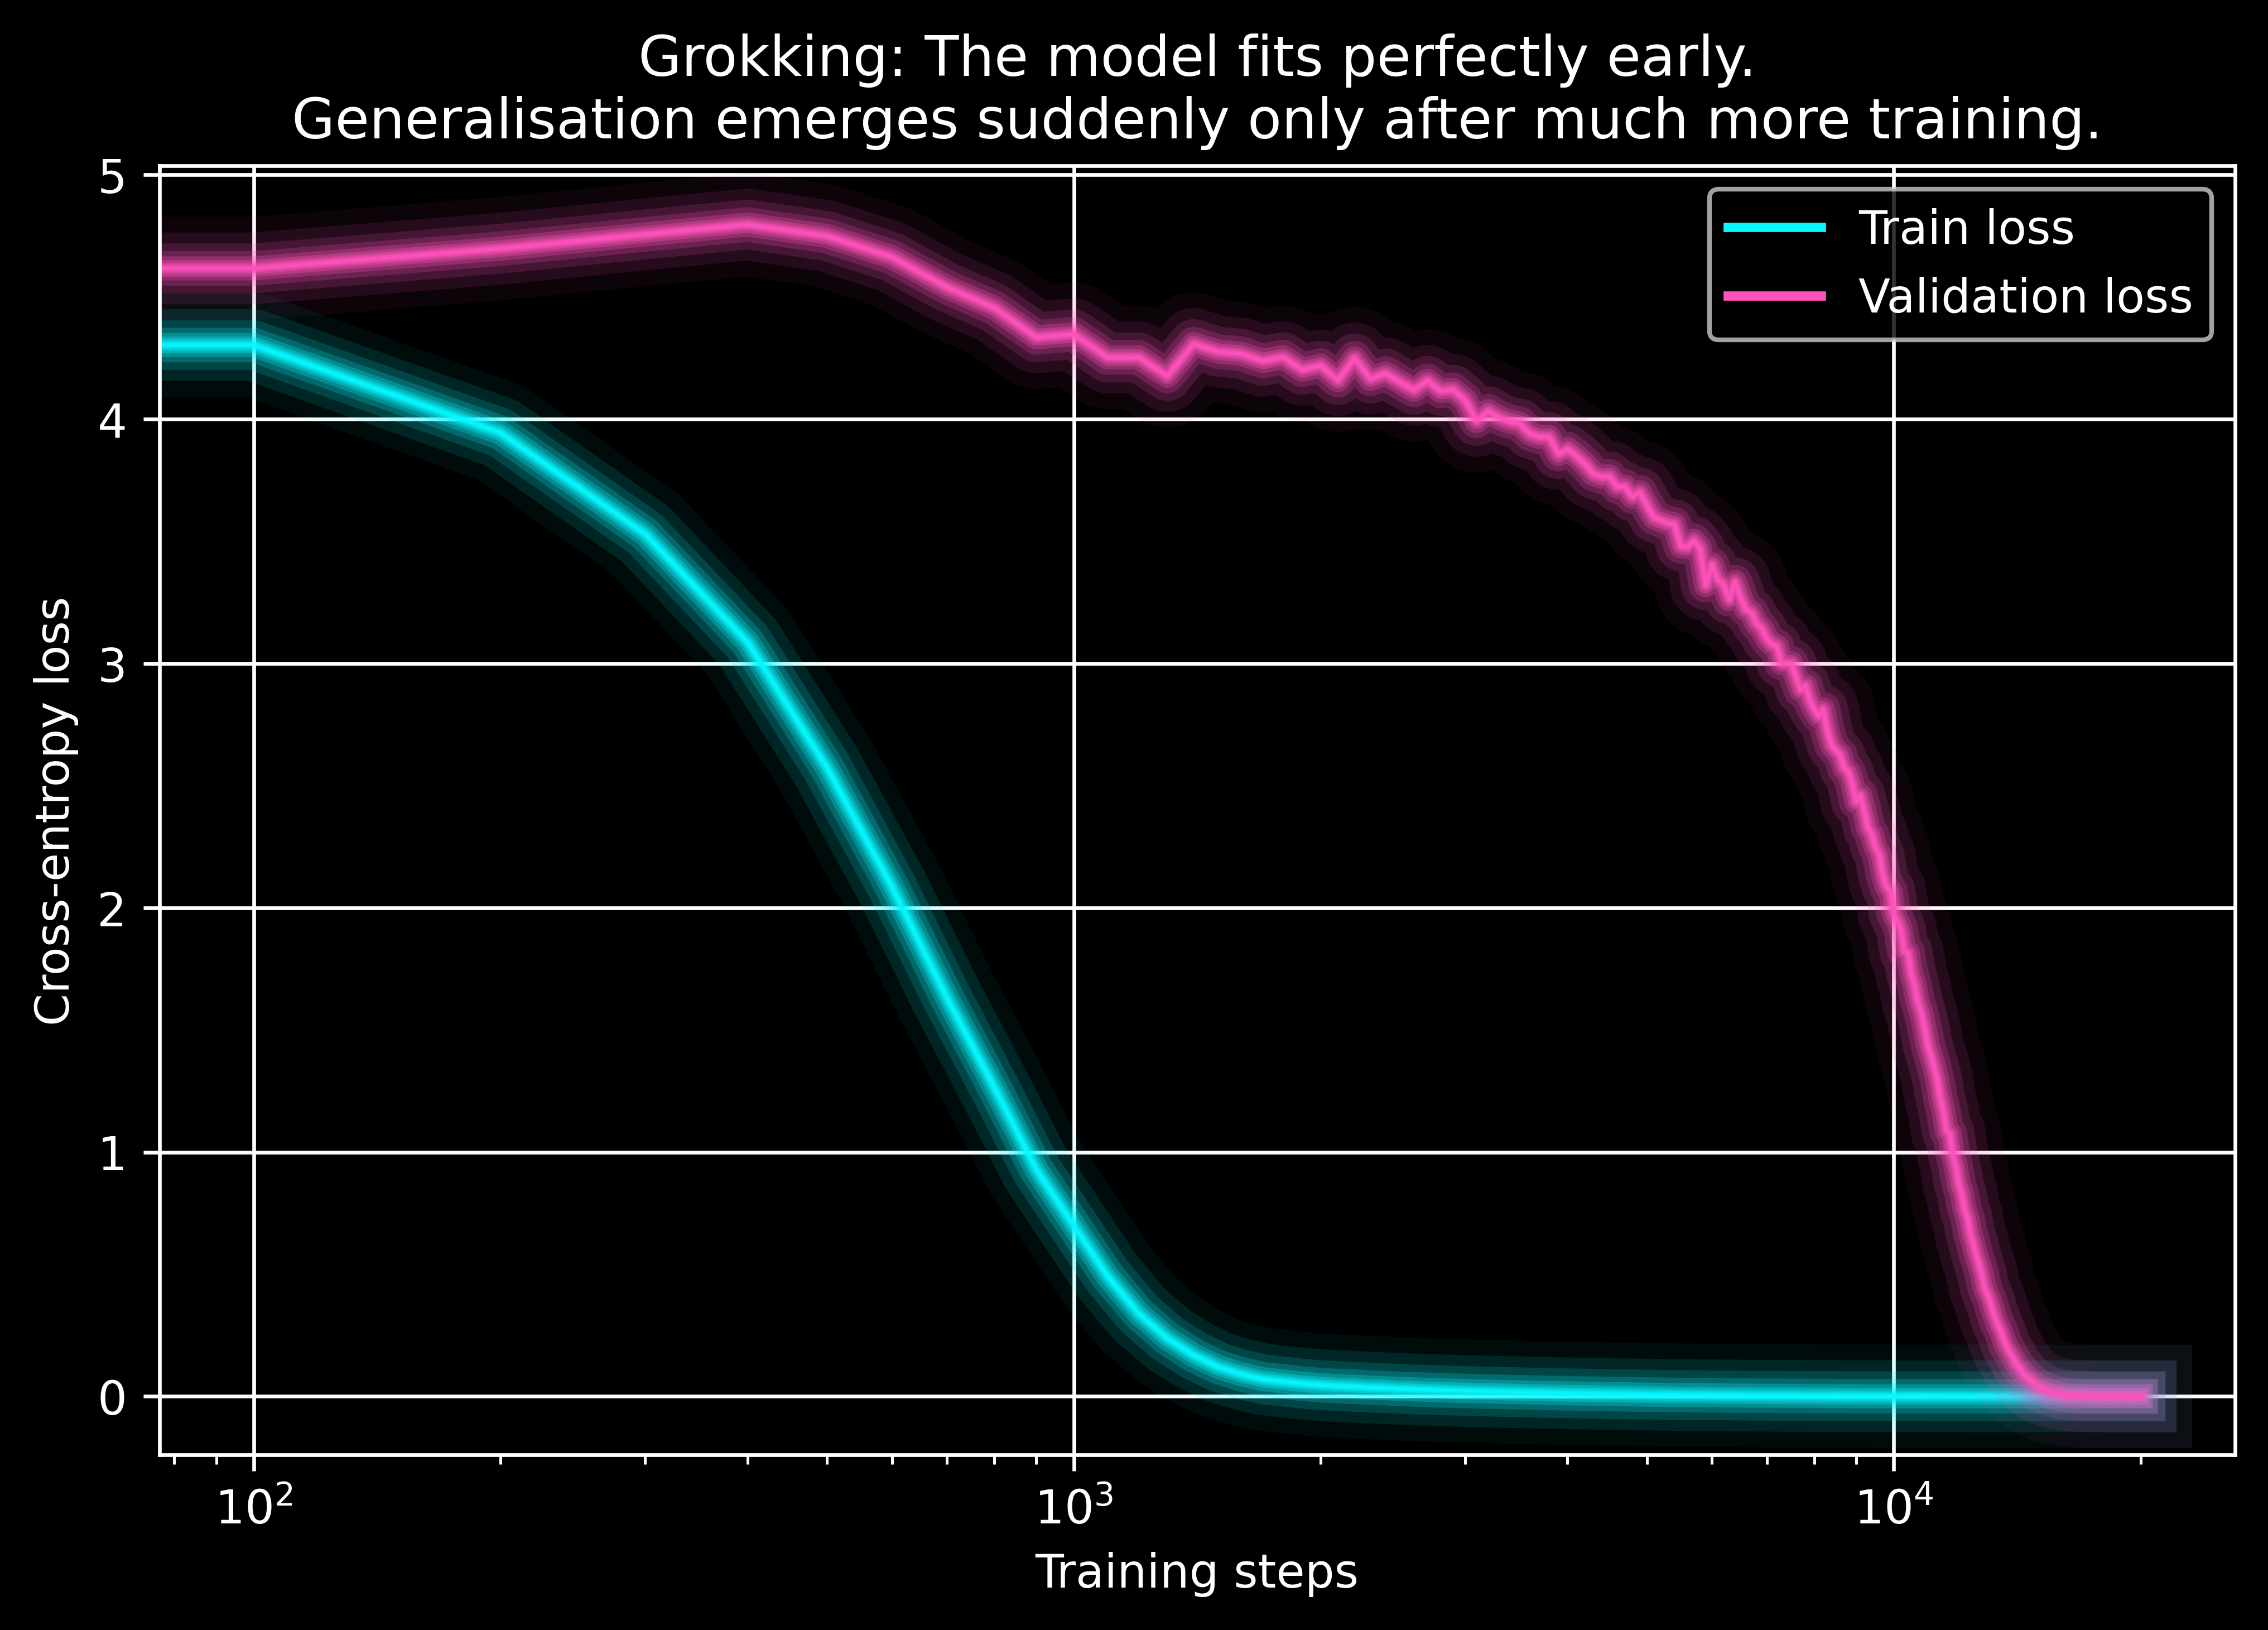

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 5), dpi=600)
plt.style.use("dark_background")

def neon_plot(x, y, c="#08F7FE"):
    linewidths     = np.logspace(-5, 5, 20, base=2)
    transparencies = np.linspace(1, 0, 20)

    for i, (lw, alpha) in enumerate(zip(linewidths, transparencies)):
        plt.plot(
            x, y,
            color=c,
            lw=lw,
            alpha=alpha
        )

# Neon colours
train_color = "#08F7FE"  # cyan
val_color   = "#FE53BB"  # magenta

neon_plot(steps, train_losses, c=train_color)
neon_plot(steps, val_losses,   c=val_color)



# --- Manual legend ---
legend_elements = [
    Line2D([0], [0], color=train_color, lw=2, label="Train loss"),
    Line2D([0], [0], color=val_color,   lw=2, label="Validation loss"),
]

plt.legend(handles=legend_elements)
plt.grid(True)


plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("Cross-entropy loss")
plt.title("Grokking: The model fits perfectly early.\nGeneralisation emerges suddenly only after much more training.")

plt.savefig("2_grokking.png")
plt.show()
